In [144]:
from tensorflow.keras.datasets import fashion_mnist

In [145]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [146]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


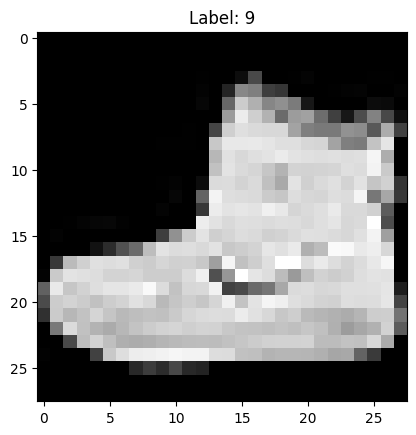

In [147]:
import matplotlib.pyplot as plt

# 0th image
plt.imshow(x_train[0], cmap='gray')   # CIFAR ho to cmap hata dena
plt.title(f"Label: {y_train[0]}")
plt.show()

In [148]:
print(x_train.min(), x_train.max(), x_train.dtype)

0 255 uint8


In [149]:
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0

In [150]:
print(x_train.min(), x_train.max(), x_train.dtype)

0.0 1.0 float32


In [151]:
import numpy as np

mean = x_train.mean()
std  = x_train.std()

print(mean)
print(std)

0.2860402
0.3530239


In [152]:
x_train = (x_train - mean) / std
x_test = (x_test - mean) / std

In [153]:
import numpy as np

mean = x_train.mean()
std  = x_train.std()

print(mean)
print(std)

1.1828182e-06
1.0000026


In [154]:
print(type(x_train), type(y_train))
print(getattr(x_train, "shape", None), getattr(x_train, "dtype", None))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(60000, 28, 28) float32


In [155]:
import torch
from torch.utils.data import TensorDataset

# numpy -> torch tensor
x_train_t = torch.from_numpy(x_train).float()
y_train_t = torch.from_numpy(y_train).long()

x_test_t  = torch.from_numpy(x_test).float()
y_test_t  = torch.from_numpy(y_test).long()

# labels (N,1) ho sakte hain, isliye squeeze
y_train_t = y_train_t.squeeze()
y_test_t  = y_test_t.squeeze()

# Fashion-MNIST: (N,28,28) -> (N,1,28,28)  (CNN ke liye channel add)
x_train_t = x_train_t.unsqueeze(1)
x_test_t  = x_test_t.unsqueeze(1)

train_dataset = TensorDataset(x_train_t, y_train_t)
test_dataset  = TensorDataset(x_test_t, y_test_t)

print(x_train_t.shape, y_train_t.shape)

torch.Size([60000, 1, 28, 28]) torch.Size([60000])


In [156]:
from torch.utils.data import DataLoader
batch_size = 64  # 4GB GPU pe safe

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

In [157]:
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10, dropout_p=0.3):
        super().__init__()

        self.features = nn.Sequential(
            # Input: (N, 1, 28, 28)
            nn.Conv2d(1, 32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # -> (N, 32, 14, 14)

            nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # -> (N, 64, 7, 7)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),                 # -> (N, 64*7*7)
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = SimpleCNN()

In [158]:
import torch.optim as optim 
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam( model.parameters(),lr = 1e-3,weight_decay=5e-4)

In [159]:
def tain_one_epoch(model,loader):
    model.train()
    total_loss,correct,total=0.0 , 0,0

    for x, y in loader:
        x, y = x, y
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits,y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() *x.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.size(0)
    return total_loss/total,correct/total     

In [160]:
@torch.no_grad()
def evaluate(model,loader):
    model.eval()
    total_loss,correct,total=0.0,0,0
    for x, y in loader:
        x, y = x, y
        logits = model(x)
        loss = criterion(logits,y)
        total_loss+= loss.item()* x.size(0)
        pred =logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total +=y.size(0)
    return total_loss/total,correct/total
        

In [161]:
import torch
train_loss,test_loss = [],[]
train_acc,test_acc = [],[]
best_acc = 0


epochs =20 
for epoch in range(1,epochs + 1):

    
   tr_loss,tr_acc = tain_one_epoch (model,train_loader)
   te_loss,te_acc = evaluate(model,test_loader)
    

   train_loss.append(tr_loss)
   test_loss.append(te_loss)
   train_acc.append(tr_acc)
   test_acc.append(te_acc)
   print(
        f"Epoch {epoch:02d} | Train loss {tr_loss:.4f} acc {tr_acc:.4f} | "
        f"Test loss {te_loss:.4f} acc {te_acc:.4f}"
    ) 
   if(te_acc>best_acc):
       best_acc = te_acc
       torch.save(model.state_dict(), "best_model.pth")
       print("Best model saved")

Epoch 01 | Train loss 0.4466 acc 0.8408 | Test loss 0.3246 acc 0.8836
Best model saved
Epoch 02 | Train loss 0.3183 acc 0.8860 | Test loss 0.2826 acc 0.8973
Best model saved
Epoch 03 | Train loss 0.2841 acc 0.8977 | Test loss 0.2845 acc 0.8956
Epoch 04 | Train loss 0.2605 acc 0.9055 | Test loss 0.2480 acc 0.9100
Best model saved
Epoch 05 | Train loss 0.2479 acc 0.9102 | Test loss 0.2796 acc 0.8984
Epoch 06 | Train loss 0.2322 acc 0.9157 | Test loss 0.2391 acc 0.9129
Best model saved
Epoch 07 | Train loss 0.2268 acc 0.9181 | Test loss 0.2352 acc 0.9163
Best model saved
Epoch 08 | Train loss 0.2173 acc 0.9215 | Test loss 0.2368 acc 0.9140
Epoch 09 | Train loss 0.2100 acc 0.9241 | Test loss 0.2260 acc 0.9184
Best model saved
Epoch 10 | Train loss 0.2045 acc 0.9259 | Test loss 0.2450 acc 0.9107
Epoch 11 | Train loss 0.2018 acc 0.9273 | Test loss 0.2285 acc 0.9153
Epoch 12 | Train loss 0.1981 acc 0.9277 | Test loss 0.2331 acc 0.9125
Epoch 13 | Train loss 0.1912 acc 0.9304 | Test loss 0.2249

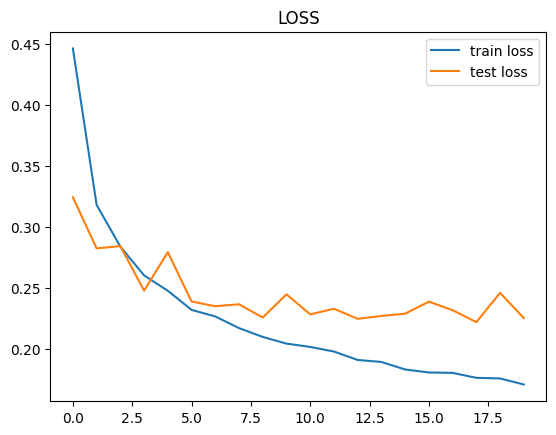

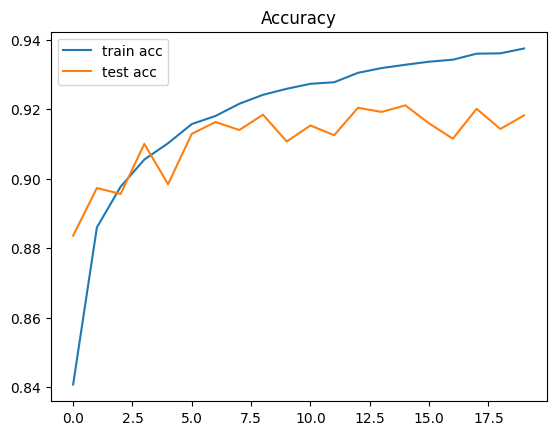

In [162]:
import matplotlib.pyplot as plt
plt.figure
plt.plot(train_loss, label = "train loss")
plt.plot(test_loss, label = "test loss")
plt.legend()
plt.title("LOSS")
plt.show()

plt.figure
plt.plot(train_acc, label = "train acc")
plt.plot(test_acc, label = "test acc")
plt.legend()
plt.title("Accuracy")
plt.show()